# Transfer Learning for Image Classification: Chicken vs Duck

## 1. Loading the Dataset

In [1]:
!unzip -q /content/data.zip

## 2. Importing Libraries

In [2]:
# Standard Libraries
import os
import sys
import time
import copy
import glob
import random
import warnings
from tempfile import TemporaryDirectory

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import classification_report
from PIL import Image

# PyTorch Libraries
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from torchvision import models

# Suppress warnings
warnings.filterwarnings('ignore')

## 3. Data Preparation

### 3.1 Define Dataset Paths

In [3]:
# Define paths to the image directories
CHICKEN_IMAGES_PATH = "/content/data/chicken-images/"
DUCK_IMAGES_PATH = "/content/data/duck-images/"

# Get lists of image directories
chicken_images_dir = glob.glob(f"{CHICKEN_IMAGES_PATH}/train/*")
duck_images_dir = glob.glob(f"{DUCK_IMAGES_PATH}/train/*")

### 3.2 Create Dataset Annotations

In [4]:
def annotations(paths: list[str]):
    """
    Creates DataFrames containing image paths and class labels for train, validation, and test sets.

    Args:
        paths: List of paths to image directories

    Returns:
        Three DataFrames (train, val, test) with columns 'path' and 'class'
    """
    def get_df(split):
        data = []
        for p in paths:
            folder = os.path.join(p, split)
            label = p.split("/")[3]  # Extract class name from path
            files = [f"{p}/{split}/{f}" for f in os.listdir(folder)]
            data.extend([(f, label) for f in files])
        return pd.DataFrame(data, columns=["path", "class"]).reset_index(drop=True)

    return get_df("train"), get_df("val"), get_df("test")

In [5]:
# Generate annotations for train, validation, and test sets
train, val, test = annotations([CHICKEN_IMAGES_PATH, DUCK_IMAGES_PATH])

### 3.3 Analyze Dataset Distribution

<Figure size 1000x600 with 0 Axes>

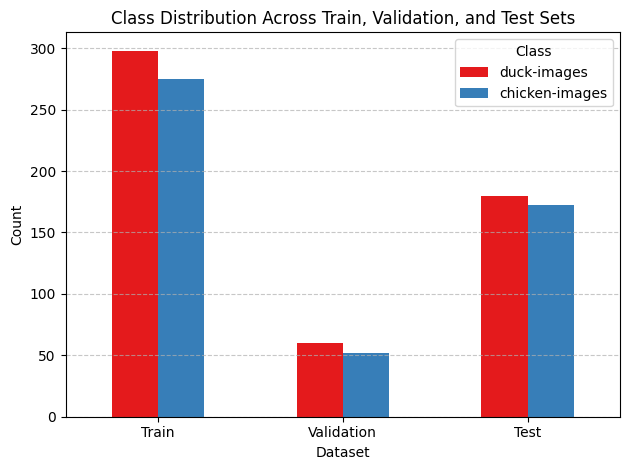

In [7]:
# Get class counts for each dataset
train_counts = train['class'].value_counts()
val_counts = val['class'].value_counts()
test_counts = test['class'].value_counts()

# Create DataFrame for visualization
df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}).fillna(0).astype(int)

df = df.T

# Plot class distribution
plt.figure(figsize=(10, 6))
df.plot(kind='bar', color=sns.color_palette('Set1'))

plt.title('Class Distribution Across Train, Validation, and Test Sets')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 4. Custom Dataset and Transformations

### 4.1 Define Custom Dataset Class

In [8]:
class ChickenOrDuck(Dataset):
    """
    Custom Dataset class for Chicken vs Duck classification.

    Args:
        annotations_file: DataFrame containing image paths and class labels
        transforms: Transformations to apply to images
    """
    def __init__(self, annotations_file, transforms=None):
        self.annotations_file = annotations_file
        self.transforms = transforms or transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, idx):
        img_path, label = self.annotations_file.loc[idx, ["path", "class"]]

        # Convert class label to numeric: 1 for chicken, 0 for duck
        label = 1 if label == "chicken-images" else 0

        # Load and preprocess the image
        image = Image.open(img_path).convert("RGB")
        image = image.resize((256, 256))  # Resize to fixed size
        image = self.transforms(image)  # Apply transformations

        return image, label

    def __len__(self):
        return len(self.annotations_file)

### 4.2 Define Image Transformations

In [9]:
# ImageNet mean and std values for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def get_image_transforms(phase: str):
    """
    Creates image transformations for training or validation/testing phases.

    Args:
        phase: Either 'train' or 'val'

    Returns:
        A composition of transformations
    """
    if phase == 'train':
        return transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Data augmentation
            transforms.RandomVerticalFlip(),    # Data augmentation
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color augmentation
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=mean, std=std),  # Normalize using ImageNet stats
        ])
    elif phase == 'val':
        return transforms.Compose([
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize(mean=mean, std=std),  # Normalize using ImageNet stats
        ])
    else:
        raise ValueError("Invalid phase: should be 'train' or 'val'")

# Create transformations for training and validation/test
train_transform = get_image_transforms('train')
val_transform = get_image_transforms('val')

### 4.3 Create Dataset Instances

In [10]:
# Create dataset instances
train_dataset = ChickenOrDuck(annotations_file=train, transforms=train_transform)
val_dataset = ChickenOrDuck(annotations_file=val, transforms=val_transform)
test_dataset = ChickenOrDuck(annotations_file=test, transforms=val_transform)

### 4.4 Configure DataLoaders

In [11]:
# Set batch size and device (GPU if available, otherwise CPU)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Create DataLoaders for batch processing
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Verify the size of each dataloader
print(f"Number of batches - Train: {len(train_dataloader)}, Val: {len(val_dataloader)}, Test: {len(test_dataloader)}")

Number of batches - Train: 36, Val: 7, Test: 22


In [14]:
# Verify the size of each dataset
print(f"Number of images - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Number of images - Train: 573, Val: 112, Test: 352


## 5. Model Training

### 5.1 Define Training Function

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    """
    Train and validate the model.

    Args:
        model: The neural network model
        criterion: Loss function
        optimizer: Optimization algorithm
        scheduler: Learning rate scheduler
        num_epochs: Number of training epochs

    Returns:
        Trained model with best validation accuracy
    """
    since = time.time()
    best_acc = 0.0

    # Track metrics for plotting
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 50)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # Set model to training mode or evaluation mode
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Use appropriate dataloader and dataset size
            dataloader = train_dataloader if phase == 'train' else val_dataloader
            dataset_size = len(train_dataset) if phase == 'train' else len(val_dataset)

            # Iterate over data batches
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass - track history only in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double().item() / dataset_size

            # Store metrics for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Step the scheduler in training phase
            if phase == 'train':
                scheduler.step()

            # Save the best model based on validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pt')
                print(f"Saved new best model with validation accuracy: {best_acc:.4f}")

        print() # Empty line between epochs

    # Print training time statistics
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accs, 'b-', label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load the best model weights
    model.load_state_dict(torch.load('best_model.pt'))
    return model

### 5.2 Initialize and Configure Model

In [16]:
def initialize_model():
    """
    Initialize a pre-trained ResNet18 model for transfer learning.

    Returns:
        model: Configured ResNet18 model
        criterion: Loss function
        optimizer: Optimization algorithm
        scheduler: Learning rate scheduler
    """
    # Initialize ResNet18 model with pre-trained weights
    model = models.resnet18(weights='IMAGENET1K_V1')

    # Print model structure
    print("Using ResNet18 architecture with pre-trained ImageNet weights")

    # Replace the final fully connected layer for binary classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: chicken and duck

    # Move model to the specified device
    model = model.to(device)
    print(f"Model moved to {device}")

    # Define loss function, optimizer, and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    return model, criterion, optimizer, scheduler

# Initialize model and training components
model_ft, criterion, optimizer_ft, exp_lr_scheduler = initialize_model()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.3MB/s]


Using ResNet18 architecture with pre-trained ImageNet weights
Model moved to cuda


### 5.3 Train the Model

Starting model training...
Epoch 1/15
--------------------------------------------------
Train Loss: 0.4465 Acc: 0.7731
Val Loss: 0.2808 Acc: 0.8571
Saved new best model with validation accuracy: 0.8571

Epoch 2/15
--------------------------------------------------
Train Loss: 0.2246 Acc: 0.9040
Val Loss: 0.2228 Acc: 0.9107
Saved new best model with validation accuracy: 0.9107

Epoch 3/15
--------------------------------------------------
Train Loss: 0.1723 Acc: 0.9407
Val Loss: 0.1937 Acc: 0.9107

Epoch 4/15
--------------------------------------------------
Train Loss: 0.1045 Acc: 0.9686
Val Loss: 0.1918 Acc: 0.9375
Saved new best model with validation accuracy: 0.9375

Epoch 5/15
--------------------------------------------------
Train Loss: 0.0727 Acc: 0.9808
Val Loss: 0.2067 Acc: 0.9018

Epoch 6/15
--------------------------------------------------
Train Loss: 0.0944 Acc: 0.9686
Val Loss: 0.1816 Acc: 0.9018

Epoch 7/15
--------------------------------------------------
Train Loss:

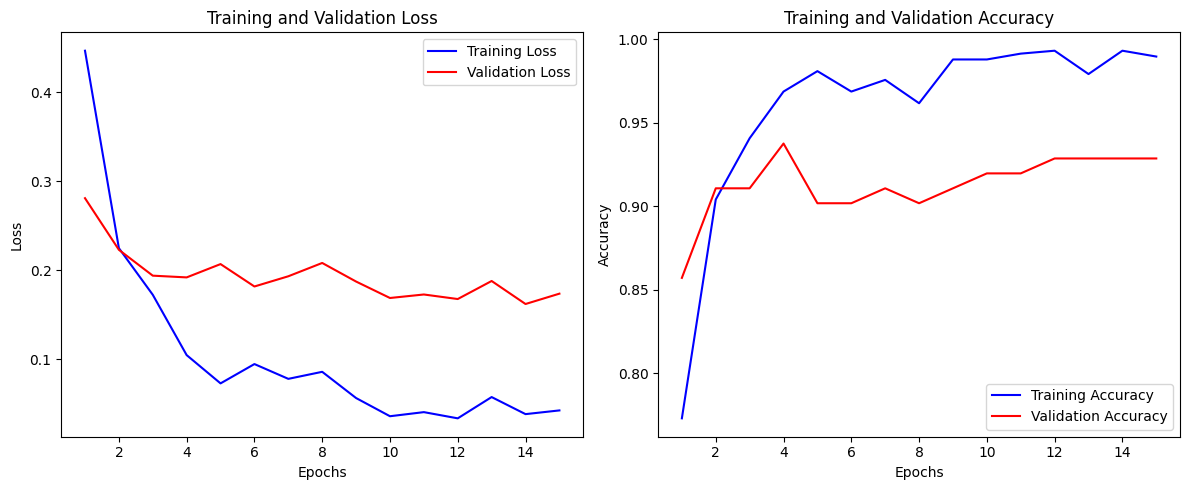

In [17]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

# Train the model
print("Starting model training...")
trained_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

## 6. Model Evaluation

### 6.1 Classification Report

In [18]:
def get_classification_report(model, dataloader, device, dataset_name=""):
    """
    Evaluate the model and generate a classification report.

    Args:
        model: Trained model
        dataloader: DataLoader for the dataset to evaluate
        device: Device to use for computation
        dataset_name: Optional name of the dataset for reporting

    Returns:
        report: Classification report as a string
    """
    print(f"Evaluating model on {dataset_name} dataset...")
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    # Disable gradient calculation for validation to save memory and computations
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Update accuracy metrics
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Collect all predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall accuracy
    accuracy = 100 * correct / total
    print(f"Overall Accuracy: {accuracy:.2f}%")

    # Generate classification report with custom class names
    report = classification_report(all_labels, all_preds, target_names=["Duck", "Chicken"])

    return report

# Evaluate on validation set
val_report = get_classification_report(trained_model, val_dataloader, device, "validation")
print("Classification Report (Validation Set):")
print(val_report)

# Evaluate on test set
test_report = get_classification_report(trained_model, test_dataloader, device, "test")
print("\nClassification Report (Test Set):")
print(test_report)

Evaluating model on validation dataset...
Overall Accuracy: 93.75%
Classification Report (Validation Set):
              precision    recall  f1-score   support

        Duck       0.91      0.98      0.94        60
     Chicken       0.98      0.88      0.93        52

    accuracy                           0.94       112
   macro avg       0.94      0.93      0.94       112
weighted avg       0.94      0.94      0.94       112

Evaluating model on test dataset...
Overall Accuracy: 96.31%

Classification Report (Test Set):
              precision    recall  f1-score   support

        Duck       0.94      0.99      0.96       180
     Chicken       0.99      0.94      0.96       172

    accuracy                           0.96       352
   macro avg       0.96      0.96      0.96       352
weighted avg       0.96      0.96      0.96       352

